In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../models')

from models import firstordermodel, secondordermodel
from tools import stochasticSimulation, derive_regimes, solve_ivp_discrete, \
                    smooth_dap, sol_ivp_wrapper, smooth_regime, cost, sigmoid,\
                    simulate_MPC



%load_ext autoreload
%autoreload 2

# Data

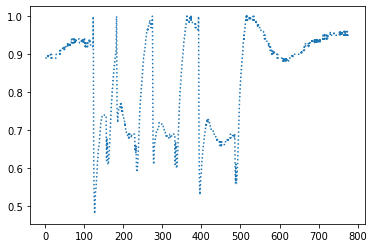

In [2]:
data_full = pd.read_csv('/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/CODE/switching_time_optimization/data/high_tc_20190913.csv', sep = ';', encoding="latin1", header = 0, index_col = 0)


data_full.index = pd.to_datetime(data_full.index, format='%Y-%m-%d %H:%M:%S')
data = data_full.filter(['A40_A_CompCap'], axis=1)
data['A40_A_CompCap'] = data['A40_A_CompCap']/100
data['t'] = 60 * data_full.index.hour + data_full.index.minute + 1/60 * data_full.index.second
data['t'] = data['t'] - data['t'][0]


plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')

## First order model

In [3]:
# Define model
lambda_MELT = 0.00183*60
lambda_IDLE = 0.00085*60
mu_MELT = 66.92400 
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([mu_IDLE, mu_MELT, lambda_IDLE, lambda_MELT, sigma, R])
m1 = firstordermodel(pars)

T = 60 * 24
x0 = 90


# Extract switch solution from C++
switches = genfromtxt('results/optimal_pars.csv', delimiter=',')
tau_IDLE_all, tau_MELT_all = derive_regimes(switches,T,1)
tau_IDLE, tau_MELT = derive_regimes(switches,T,0)

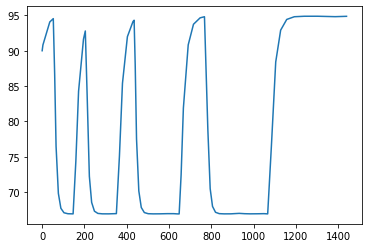

In [4]:
# Plot solution
sol = solve_ivp(m1.f, [0, T], [x0], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(sol.t,sol.y[0])

## Second order model

In [5]:
# Define model
mu_IDLE = 857.67384863 
mu_MELT = 686.5294216
omega_IDLE = 0.0597560
omega_MELT = 0.2612345
xi_IDLE = 0.3504557
xi_MELT = 0.3426913
logsigma = np.array([-7.7329708, 2.0893133])
logR = -7.0306394

pars = np.array([mu_IDLE, mu_MELT, omega_IDLE, omega_MELT, xi_IDLE, xi_MELT, logsigma, logR])
m2 = secondordermodel(pars)

### With test switches from data

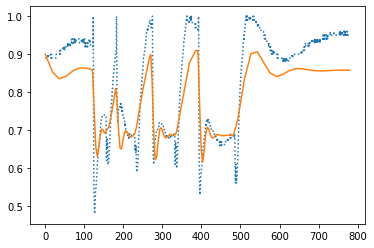

In [6]:
T = data['t'][-1]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_IDLE_all_data, tau_MELT_all_data = derive_regimes(switches_data,T,1)
x0 = np.array([2.6659426, 899.8884004])
sol = solve_ivp(m2.f, [0, T], [x0[0], x0[1]], args=(tau_MELT_all_data,tau_IDLE_all_data))
plt.plot(data['t'], data['A40_A_CompCap'], ls = 'dotted')
plt.plot(sol.t, sol.y[1]/1000)



### With switches from c++ example (with example cost function!)

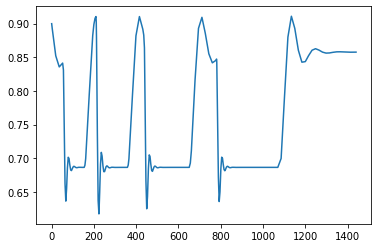

In [7]:
T = 60 * 24
x0 = np.array([2.6659426, 899.8884004])
sol = solve_ivp(m2.f, [0, T], [x0[0], x0[1]], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(sol.t, sol.y[1] * 1/1000)

## Model simulation

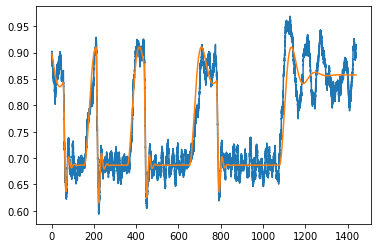

In [8]:
# Simulate from model
tf = 60*24
dt = 0.01
x0 = np.array([2.6659426, 899.8884004])
#x0 = np.array([90])
np.random.seed(144257)
T, X, Y, Z = stochasticSimulation(m2,switches,x0,tf,dt)
T_ode, X_ode, Z_ode = solve_ivp_discrete(m2,x0,switches,tf,T)
plt.plot(T,Z)
plt.plot(T_ode, Z_ode)

#T_ode2, X_ode2, Z_ode2,  = sol_ivp_wrapper(m1,x0,switches,tf,T)
#plt.plot(T_ode2, Z_ode2)

In [9]:
# Day Ahead Prices and power constants
dap = 1/1000000 * np.array([15.5,31.,21.,35.,36.,35.,28.,33.,28.,41.,44.,36.,32.,28.,24.,25.,34.,36.,41.,37.,35.,39.,34.,24.])
k = 12400.
k_MELT = 250.
k_IDLE = 9.

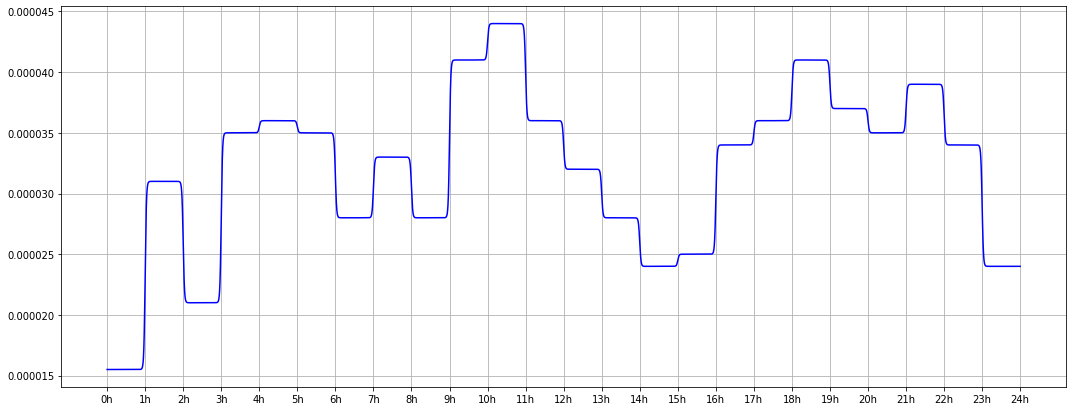

In [10]:
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T,smooth_dap(dap,T),color='b')
ax.set_xticks(np.arange(0,dap.size+1,1)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,dap.size+1,1) * 60.])
ax.grid()

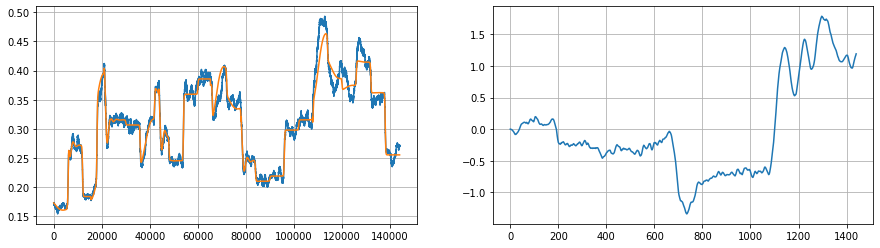

In [11]:
cost_true, cost_acc_true = cost(Z,T,switches,dap,k,k_MELT,k_IDLE)
cost_exp, cost_acc_exp = cost(Z_ode,T_ode,switches,dap,k,k_MELT,k_IDLE)

fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(121)
plt.plot(cost_true)
plt.plot(cost_exp)
ax.grid()

ax = fig.add_subplot(122)
plt.plot(T[1:],cost_acc_true - cost_acc_exp)
ax.grid()

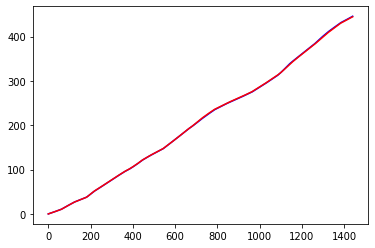

In [12]:
plt.plot(T[1:],cost_acc_true, color = 'blue')
plt.plot(T_ode[1:],cost_acc_exp, color = 'red')

## Loop : Plan 2 days, simulate 1 day

In [13]:
nswitches = 10
tf_sim = 60 * 24
tf_ph = 60 * 48

In [14]:
prices = pd.read_csv('../data/elspot-prices_2013_hourly_dkk.csv', index_col=0, skiprows=2,header=0)  
prices = prices[{'Hours','DK1'}]
prices = prices.apply(lambda x: x.str.replace(',','.'))
prices


,Hours,DK1
01-01-2013,00 - 01,104.66
01-01-2013,01 - 02,82.5
01-01-2013,02 - 03,63.41
01-01-2013,03 - 04,0.75
01-01-2013,04 - 05,14.99
...,...,...
31-12-2013,19 - 20,226.01
31-12-2013,20 - 21,209.97
31-12-2013,21 - 22,149.63
31-12-2013,22 - 23,214.6


In [32]:
model = m2
x0 = np.array([2.6659426, 899.8884004])
start_date = '01-01-2013'
n_days = 30
dt = 0.01
seed = 1234
save_to_file = 1
nswitches = 10
history = simulate_MPC(model,x0,n_days,nswitches,prices,k,k_MELT,k_IDLE,dt,start_date,seed,save_to_file) 

Simulating day 0
Simulating day 1
Simulating day 2
Simulating day 3
Simulating day 4
Simulating day 5
Simulating day 6
Simulating day 7
Simulating day 8
Simulating day 9
Simulating day 10
Simulating day 11
Simulating day 12
Simulating day 13
Simulating day 14
Simulating day 15
Simulating day 16
Simulating day 17
Simulating day 18
Simulating day 19
Simulating day 20
Simulating day 21
Simulating day 22
Simulating day 23
Simulating day 24
Simulating day 25
Simulating day 26
Simulating day 27
Simulating day 28
Simulating day 29


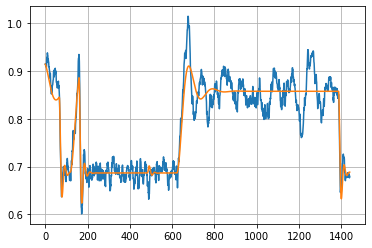

In [25]:
day = 1
plt.plot(history['T'][0],history['Z'][day])
plt.plot(history['T'][0],history['Z_ode'][day])
plt.grid()

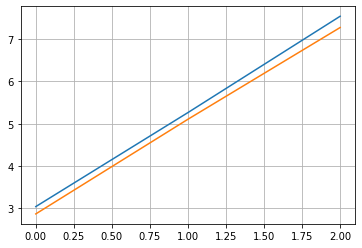

In [26]:
plt.plot(range(n_days),np.cumsum(history['expected_price']))
plt.plot(range(n_days),np.cumsum(history['true_price']))
plt.grid()

In [27]:
history['expected_price'] - history['true_price']

array([ 0.17367294, -0.01539227,  0.10886295])